In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from efficientkan import KAN

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load MNIST dataset

transform = transforms.Compose([
    #torchvision.transforms.Resize(14),      # Resize the image
    transforms.ToTensor(),                  # Convert images to PyTorch tensors and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize to mean=0.5, std=0.5
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [3]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

img_res = images.shape[3]

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


In [4]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        self.layers = layers
        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.build_layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.build_layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters




class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.layers = layers
        self.num_parameters = self.count_params(layers, grid_size)
        self.build_layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.build_layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [5]:
def train_and_evaluate(model, trainloader, valloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    for epoch in range(num_epochs):

# Train
        model.train()
        train_loss = 0
        train_acc = 0

        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, img_res*img_res).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()

        train_losses.append(train_loss / i)
        train_accs.append(train_acc / i)

        t = time()-start
        times.append(t)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / i:.4f}, Train Accuracy: {train_acc / i:.4f}, Time: {t:.2f}s")


# Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, img_res*img_res).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        val_losses.append(val_loss / i)
        val_accs.append(val_acc / i)

        print(f"\t     Valid Loss: {val_loss / i:.4f}, Valid Accuracy: {val_acc / i:.4f}\n")


    return train_losses, train_accs, val_losses, val_accs, times

In [6]:
def build_data_frame(model, num_epochs, train_losses, train_accs, val_losses, val_accs, time, separator):

    df = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses],
        'Loss (v)': [i for i in val_losses],
        'Accuracy (t)': [i for i in train_accs],
        'Accuracy (v)': [i for i in val_accs],
        'Time': [i for i in time]
        })
    
    df = pd.concat([df, pd.DataFrame([{'Epoch': 'Mean', 'Time': df['Time'].mean()}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{'Epoch': f'Params: {model.num_parameters}'}])], ignore_index=True)
    df = pd.concat([df, separator], ignore_index=True)

    return df

In [7]:
# Define models and parameters

model_list_mlp = [
    #MyMLP([img_res*img_res, 128, 10]),
    #MyMLP([img_res*img_res, 64, 10]),
    MyMLP([img_res*img_res, 15, 10]),
    #MyMLP([img_res*img_res, 5, 10]),
    #MyMLP([img_res*img_res, 10, 10, 10]),
    #MyMLP([img_res*img_res, 5, 5, 10]),
    ]
model_list_kan = [
    #MyKAN([img_res*img_res, 128, 10], grid_size=3),
    #MyKAN([img_res*img_res, 64, 10], grid_size=3),
    #MyKAN([img_res*img_res, 10, 10], grid_size=3),
    MyKAN([img_res*img_res, 5, 10], grid_size=3),
    #MyKAN([img_res*img_res, 10, 10, 10], grid_size=3),
    #MyKAN([img_res*img_res, 5, 5, 10], grid_size=3)
    ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

df_mlp = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
df_kan = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp = train_and_evaluate(model_mlp, trainloader, valloader, device, num_epochs, optimizer_mlp, criterion)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan = train_and_evaluate(model_kan, trainloader, valloader, device, num_epochs, optimizer_kan, criterion)

    single_df_mlp = build_data_frame(model_mlp, num_epochs, train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp, separator)
    single_df_kan = build_data_frame(model_kan, num_epochs, train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan, separator)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)

Training model "MyMLP" [784, 15, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11935



100%|██████████| 938/938 [00:06<00:00, 137.35it/s]


Epoch [1/10], Train Loss: 0.5985, Train Accuracy: 0.8289, Time: 6.83s
	     Valid Loss: 0.3754, Valid Accuracy: 0.8927



100%|██████████| 938/938 [00:06<00:00, 149.46it/s]


Epoch [2/10], Train Loss: 0.3484, Train Accuracy: 0.9001, Time: 6.28s
	     Valid Loss: 0.3255, Valid Accuracy: 0.9070



100%|██████████| 938/938 [00:06<00:00, 148.97it/s]


Epoch [3/10], Train Loss: 0.3234, Train Accuracy: 0.9079, Time: 6.30s
	     Valid Loss: 0.3127, Valid Accuracy: 0.9152



100%|██████████| 938/938 [00:06<00:00, 143.36it/s]


Epoch [4/10], Train Loss: 0.3123, Train Accuracy: 0.9111, Time: 6.54s
	     Valid Loss: 0.3044, Valid Accuracy: 0.9203



100%|██████████| 938/938 [00:06<00:00, 148.46it/s]


Epoch [5/10], Train Loss: 0.3038, Train Accuracy: 0.9136, Time: 6.32s
	     Valid Loss: 0.3070, Valid Accuracy: 0.9185



100%|██████████| 938/938 [00:06<00:00, 148.79it/s]


Epoch [6/10], Train Loss: 0.2978, Train Accuracy: 0.9149, Time: 6.31s
	     Valid Loss: 0.2988, Valid Accuracy: 0.9216



100%|██████████| 938/938 [00:06<00:00, 148.96it/s]


Epoch [7/10], Train Loss: 0.2936, Train Accuracy: 0.9172, Time: 6.30s
	     Valid Loss: 0.3006, Valid Accuracy: 0.9189



100%|██████████| 938/938 [00:06<00:00, 147.94it/s]


Epoch [8/10], Train Loss: 0.2884, Train Accuracy: 0.9191, Time: 6.34s
	     Valid Loss: 0.2910, Valid Accuracy: 0.9211



100%|██████████| 938/938 [00:06<00:00, 146.03it/s]


Epoch [9/10], Train Loss: 0.2839, Train Accuracy: 0.9208, Time: 6.42s
	     Valid Loss: 0.3055, Valid Accuracy: 0.9182



100%|██████████| 938/938 [00:06<00:00, 145.23it/s]


Epoch [10/10], Train Loss: 0.2810, Train Accuracy: 0.9190, Time: 6.46s
	     Valid Loss: 0.3004, Valid Accuracy: 0.9184

Training model "MyKAN" [784, 5, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11910



100%|██████████| 938/938 [00:07<00:00, 120.48it/s]


Epoch [1/10], Train Loss: 0.8648, Train Accuracy: 0.7435, Time: 7.79s
	     Valid Loss: 0.4920, Valid Accuracy: 0.8632



100%|██████████| 938/938 [00:07<00:00, 123.48it/s]


Epoch [2/10], Train Loss: 0.4377, Train Accuracy: 0.8776, Time: 7.60s
	     Valid Loss: 0.3844, Valid Accuracy: 0.8984



100%|██████████| 938/938 [00:07<00:00, 123.62it/s]


Epoch [3/10], Train Loss: 0.3722, Train Accuracy: 0.8957, Time: 7.59s
	     Valid Loss: 0.3665, Valid Accuracy: 0.9024



100%|██████████| 938/938 [00:07<00:00, 122.85it/s]


Epoch [4/10], Train Loss: 0.3416, Train Accuracy: 0.9031, Time: 7.64s
	     Valid Loss: 0.3453, Valid Accuracy: 0.9073



100%|██████████| 938/938 [00:07<00:00, 125.01it/s]


Epoch [5/10], Train Loss: 0.3212, Train Accuracy: 0.9090, Time: 7.50s
	     Valid Loss: 0.3204, Valid Accuracy: 0.9155



100%|██████████| 938/938 [00:07<00:00, 125.82it/s]


Epoch [6/10], Train Loss: 0.3083, Train Accuracy: 0.9128, Time: 7.46s
	     Valid Loss: 0.3191, Valid Accuracy: 0.9163



100%|██████████| 938/938 [00:07<00:00, 125.91it/s]


Epoch [7/10], Train Loss: 0.2974, Train Accuracy: 0.9156, Time: 7.45s
	     Valid Loss: 0.3132, Valid Accuracy: 0.9161



100%|██████████| 938/938 [00:07<00:00, 126.16it/s]


Epoch [8/10], Train Loss: 0.2879, Train Accuracy: 0.9176, Time: 7.44s
	     Valid Loss: 0.3153, Valid Accuracy: 0.9127



100%|██████████| 938/938 [00:07<00:00, 124.88it/s]


Epoch [9/10], Train Loss: 0.2838, Train Accuracy: 0.9190, Time: 7.51s
	     Valid Loss: 0.3091, Valid Accuracy: 0.9195



100%|██████████| 938/938 [00:07<00:00, 126.18it/s]


Epoch [10/10], Train Loss: 0.2776, Train Accuracy: 0.9206, Time: 7.43s
	     Valid Loss: 0.3027, Valid Accuracy: 0.9207



In [8]:
#print(df_mlp)
df_mlp.to_csv('results_mlp.csv', index = False)
df_kan.to_csv('results_kan.csv', index = False)

Plotting MLP

/tmp/ipykernel_4980/373705896.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


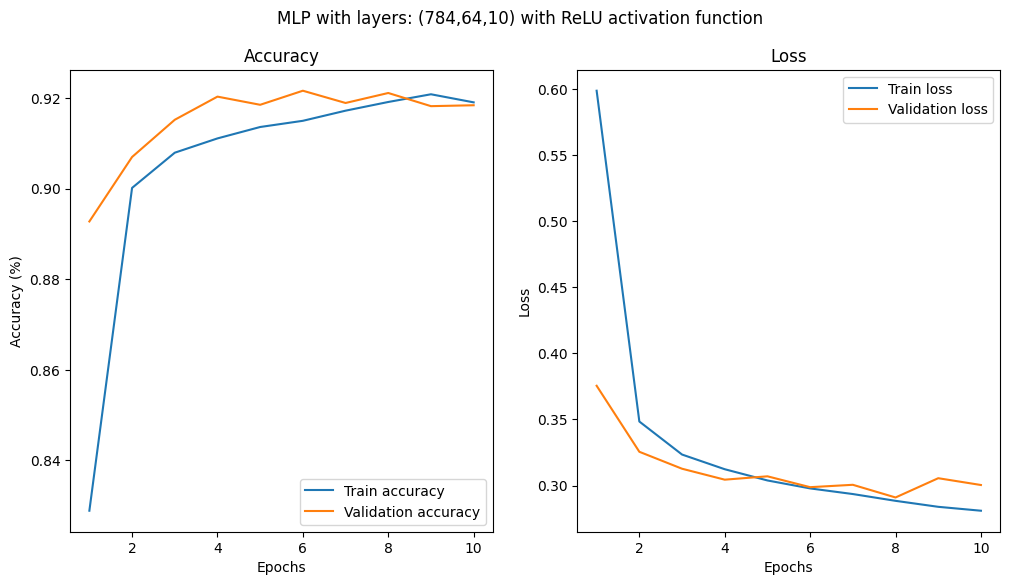

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_mlp, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_mlp, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_mlp, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_mlp, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('MLP with layers: (784,64,10) with ReLU activation function')
fig.show()

Plotting KAN

/tmp/ipykernel_4980/1405184315.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


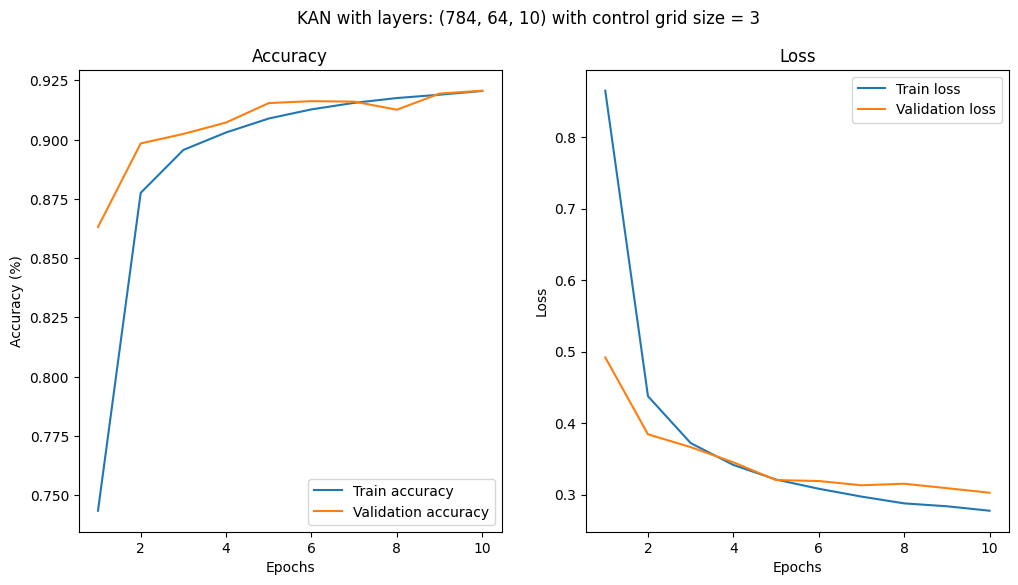

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_kan, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_kan, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_kan, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_kan, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('KAN with layers: (784, 64, 10) with control grid size = 3')
fig.show()